<a href="https://colab.research.google.com/github/5234560002ebnida/nonfictioner/blob/main/Candlestick_strategy_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-23-8ea55c4a74b2>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'][df['Buy Signal']] = 1
<ipython-input-23-8ea55c4a74b2>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'][df['Sell Signal']] = -1
<ipython-input-23-8ea55c4a74b2>:54: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['Position'] = df['Position'].replace(to_replace=0, method='ffill')


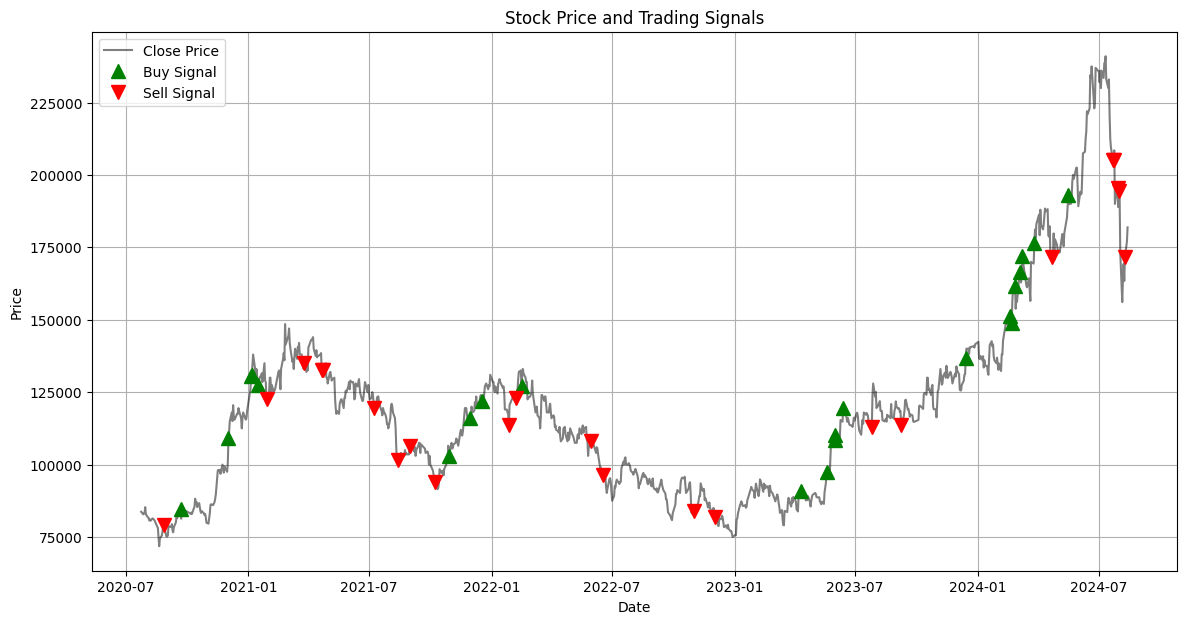

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

# 주식 데이터를 가져오는 함수
def get_price(symbol, count=1000, timeframe='day'):
    url = f"https://fchart.stock.naver.com/sise.nhn?symbol={symbol}&timeframe={timeframe}&count={count}&requestType=0"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "xml")
    columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data = []
    items = soup.find_all('item')
    for item in items:
        row = item['data'].split('|')
        data.append(row)

    df = pd.DataFrame(data, columns=columns)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df.astype(float)

# RSI 계산 함수
def calculate_rsi(df, period=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 아랫꼬리와 윗꼬리의 길이를 계산하고 매수/매도 신호를 생성하는 함수
def generate_tail_signals(df):
    df['Lower Wick'] = df[['Open', 'Close']].min(axis=1) - df['Low']
    df['Upper Wick'] = df['High'] - df[['Open', 'Close']].max(axis=1)
    average_volume = df['Volume'].mean()
    df['20MA'] = df['Close'].rolling(window=20).mean()
    df['RSI'] = calculate_rsi(df)

    # 윗꼬리가 아랫꼬리보다 3배 이상 길고, 거래량이 평균 거래량을 초과하며, RSI가 60 이상일 때, 20일 이동평균 위에서 매수 신호 생성
    df['Buy Signal'] = (df['Upper Wick'] > 3 * df['Lower Wick']) & (df['Volume'] > average_volume) & (df['RSI'] >= 60) & (df['Close'] > df['20MA'])

    # 아랫꼬리가 윗꼬리보다 1배 이상 길고, 거래량이 평균 거래량을 초과하며, RSI가 50 이하일 때, 20일 이동평균 아래에서 매도 신호 생성
    df['Sell Signal'] = (df['Lower Wick'] > 3 * df['Upper Wick']) & (df['Volume'] > average_volume) & (df['RSI'] <= 50) & (df['Close'] < df['20MA'])

    return df

# 거래 결과 평가 함수
def evaluate_trades(df, stop_loss=0.02, take_profit=0.04):
    df['Position'] = 0
    df['Position'][df['Buy Signal']] = 1
    df['Position'][df['Sell Signal']] = -1
    df['Position'] = df['Position'].replace(to_replace=0, method='ffill')

    df['Daily Returns'] = df['Close'].pct_change()
    df['Strategy Returns'] = df['Position'].shift(1) * df['Daily Returns']

    # 손절매와 이익 실현 적용
    df['Strategy Returns'] = df['Strategy Returns'].apply(lambda x: -stop_loss if x < -stop_loss else (take_profit if x > take_profit else x))

    df['Cumulative Strategy Returns'] = (df['Strategy Returns'] + 1).cumprod()
    df['Cumulative Market Returns'] = (df['Daily Returns'] + 1).cumprod()

    return df

# 매매 신호 및 전략 결과 시각화 함수
def plot_trading_signals(df):
    plt.figure(figsize=(14, 7))

    plt.plot(df.index, df['Close'], label='Close Price', color='black', alpha=0.5)

    buy_signals = df[df['Buy Signal']]
    sell_signals = df[df['Sell Signal']]

    plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='green', lw=0, label='Buy Signal')
    plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='red', lw=0, label='Sell Signal')

    plt.title('Stock Price and Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# 사용 예시
symbol = '000660'  # 삼성전자 종목코드
df = get_price(symbol)
df = generate_tail_signals(df)

# 거래 평가
df = evaluate_trades(df)

# 매매 신호 시각화
plot_trading_signals(df)




